In [2]:
from azureml.core import Workspace, Datastore, Dataset
#import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.dates as mdates

import json
import logging

from matplotlib import pyplot as plt
import os

import azureml.core
from azureml.core.experiment import Experiment

In [3]:
ws = Workspace.from_config("./config/config_2")
az_store = Datastore.get(ws, 'azureml_ds_b01')
az_dataset = Dataset.get_by_name(ws, "Petrosani_01")
#az_dataset_Turda = Dataset.get_by_name(ws, "Turda_01")
az_default_store = ws.get_default_datastore()
df = az_dataset.to_pandas_dataframe()
#df_Turda_ = az_dataset_Turda.to_pandas_dataframe()

In [18]:
data = pd.read_csv(
    "https://automlsamplenotebookdata.blob.core.windows.net/automl-sample-notebook-data/bankmarketing_train.csv"
)
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,57,technician,married,high.school,no,no,yes,cellular,may,mon,...,1,999,1,failure,-1.8,92.893,-46.2,1.299,5099.1,no
1,55,unknown,married,unknown,unknown,yes,no,telephone,may,thu,...,2,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,no
2,33,blue-collar,married,basic.9y,no,no,no,cellular,may,fri,...,1,999,1,failure,-1.8,92.893,-46.2,1.313,5099.1,no
3,36,admin.,married,high.school,no,no,no,telephone,jun,fri,...,4,999,0,nonexistent,1.4,94.465,-41.8,4.967,5228.1,no
4,27,housemaid,married,high.school,no,yes,no,cellular,jul,fri,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.963,5228.1,no


In [ ]:
from azureml.core.compute import RemoteCompute, ComputeTarget

# Create the compute config 
compute_target_name = "eastuscluster"

attach_config = RemoteCompute.attach_configuration(resource_id='/subscriptions/5e20a2e2-7522-4cb5-957f-ce42d9c2abfd/resourceGroups/AzureML02/providers/Microsoft.Compute/virtualMachines/eastuscluster',
                                                ssh_port=22,
                                                username='oguzdastan@live.dk',
                                                password="Dastan12")

# Attach the compute
compute = ComputeTarget.attach(ws, compute_target_name, attach_config)

compute.wait_for_completion(show_output=True)

In [ ]:
import numpy as np

# simple dates filter
alldatestart = '2021-01-01'
alldateend = '2021-12-31'

# dataset
# create features
mask = (df['Date_Id'] > alldatestart) & (df['Date_Id'] <= alldateend)
df_filtered = df.loc[mask]
df_filtered.loc[((df_filtered['Temp_Room'] > df_filtered['Temp_Out']) & (df_filtered['FanSpeed'] > df_filtered['FanSpeed'].mean())), 'FanSpeedDiffFromMean'] = df_filtered['FanSpeed'] - df_filtered['FanSpeed'].mean()
df_filtered.loc[(df_filtered['Temp_Room'] > df_filtered['Temp_Out']), 'TempDiff'] = df_filtered['Temp_Room'] - df_filtered['Temp_Out']

df_filtered.loc[((df_filtered['FanSpeedDiffFromMean'] > 0)), 'MeanDiffLabel'] = 1
df_filtered.loc[((df_filtered['FanSpeedDiffFromMean'] <= 0)), 'MeanDiffLabel'] = 0


mask_dif = (df_filtered['Date_Id'] > alldatestart) & (df_filtered['Date_Id'] <= alldateend) & (df_filtered['Temp_Room'] > df_filtered['Temp_Out'])
df_difference_petro = df_filtered.loc[mask_dif]

# number of centroids
K=3
Centroids = (df_difference_petro.sample(n=K))

# scatter 
plt.scatter(df_difference_petro["Temp_Out"], df_difference_petro["FanSpeed"], c="black", linewidths=0.1)
plt.scatter(Centroids["Temp_Out"],Centroids["FanSpeed"],c='red')
# label stuff
plt.xlabel('Temp_Out')
plt.ylabel('FanSpeed')

# eye candy
plt.tight_layout()
plt.show()

#######
#######

diff = 1
j=0

while(diff!=0):
    XD=df_difference_petro
    i=1
    for index1,row_c in Centroids.iterrows():
        ED=[]
        for index2,row_d in XD.iterrows():
            d1=(row_c["Temp_Out"]-row_d["Temp_Out"])**2
            d2=(row_c["FanSpeed"]-row_d["FanSpeed"])**2
            d=np.sqrt(d1+d2)
            ED.append(d)
        df_difference_petro[i]=ED
        i=i+1

    C=[]
    for index,row in df_difference_petro.iterrows():
        min_dist=row[1]
        pos=1
        for i in range(K):
            if row[i+1] < min_dist:
                min_dist = row[i+1]
                pos=i+1
        C.append(pos)
    df_difference_petro["Cluster"]=C
    Centroids_new = df_difference_petro.groupby(["Cluster"]).mean()[["FanSpeed","Temp_Out"]]
    if j == 0:
        diff=1
        j=j+1
    else:
        diff = (Centroids_new['FanSpeed'] - Centroids['FanSpeed']).sum() + (Centroids_new['Temp_Out'] - Centroids['Temp_Out']).sum()
        print(diff.sum())
    Centroids = df_difference_petro.groupby(["Cluster"]).mean()[["FanSpeed","Temp_Out"]]


color=['blue','green', 'black']
for k in range(K):
    data=df_difference_petro[df_difference_petro["Cluster"]==k+1]
    plt.scatter(data["Temp_Out"],data["FanSpeed"],c=color[k])
plt.scatter(Centroids["Temp_Out"],Centroids["FanSpeed"],c='red')
plt.xlabel('Temp_Out')
plt.ylabel('Fanspeed')
plt.show()

c:\Users\OguzX\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\indexing.py:1681: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = empty_value
c:\Users\OguzX\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\Users\OguzX\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning: 
A value is t

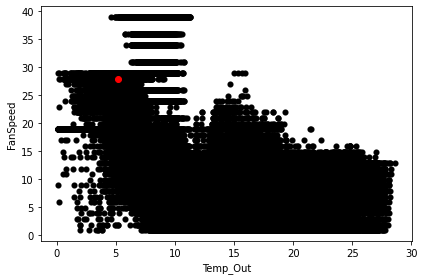

In [139]:
import numpy as np

# simple dates filter
alldatestart = '2021-06-01'
alldateend = '2021-12-31'

# dataset
# create features
mask = (df['Date_Id'] > alldatestart) & (df['Date_Id'] <= alldateend)
df_filtered = df.loc[mask]
df_filtered.loc[((df_filtered['Temp_Room'] > df_filtered['Temp_Out']) & (df_filtered['FanSpeed'] > df_filtered['FanSpeed'].mean())), 'FanSpeedDiffFromMean'] = df_filtered['FanSpeed'] - df_filtered['FanSpeed'].mean()
df_filtered.loc[(df_filtered['Temp_Room'] > df_filtered['Temp_Out']), 'TempDiff'] = df_filtered['Temp_Room'] - df_filtered['Temp_Out']

df_filtered.loc[((df_filtered['FanSpeedDiffFromMean'] > 0) & (df_filtered['TempDiff'] > 0)), 'MeanDiffLabel'] = 1
df_filtered.loc[((df_filtered['FanSpeedDiffFromMean'] <= 0) & (df_filtered['TempDiff'] <= 0)), 'MeanDiffLabel'] = 0

df_filtered.loc[((df_filtered['TempDiff'] >= 10) & (df_filtered['FanSpeedDiffFromMean'] >= 15)), 'Abnormal'] = 1
df_filtered.loc[((df_filtered['TempDiff'] < 10) & (df_filtered['FanSpeedDiffFromMean'] < 15)), 'Abnormal'] = 0


# number of centroids
K=2
Centroids = (df_filtered.sample(n=K))

# scatter 
plt.scatter(df_filtered["TempDiff"], df_filtered["FanSpeedDiffFromMean"], c="black", linewidths=0.1)
plt.scatter(Centroids["TempDiff"],Centroids["FanSpeedDiffFromMean"],c='red')
# label stuff
plt.xlabel('Temp_Out')
plt.ylabel('FanSpeed')

# eye candy
plt.tight_layout()
plt.show()

In [102]:

diff = 1
j=0

while(diff!=0):
    XD=df_filtered
    i=1
    for index1,row_c in Centroids.iterrows():
        ED=[]
        for index2,row_d in XD.iterrows():
            d1=(row_c["TempDiff"]-row_d["TempDiff"])**2
            d2=(row_c["FanSpeedDiffFromMean"]-row_d["FanSpeedDiffFromMean"])**2
            d=np.sqrt(d1+d2)
            ED.append(d)
        df_filtered[i]=ED
        i=i+1

    C=[]
    for index,row in df_filtered.iterrows():
        min_dist=row[1]
        pos=1
        for i in range(K):
            if row[i+1] < min_dist:
                min_dist = row[i+1]
                pos=i+1
        C.append(pos)
    df_filtered["Cluster"]=C
    Centroids_new = df_filtered.groupby(["Cluster"]).mean()[["FanSpeedDiffFromMean","TempDiff"]]
    if j == 0:
        diff=1
        j=j+1
    else:
        diff = (Centroids_new['FanSpeedDiffFromMean'] - Centroids['FanSpeedDiffFromMean']).sum() + (Centroids_new['TempDiff'] - Centroids['TempDiff']).sum()
        print(diff.sum())
    Centroids = df_filtered.groupby(["Cluster"]).mean()[["FanSpeedDiffFromMean","TempDiff"]]




C:\Users\OguzX\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\OguzX\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.7274340455690522
-0.8495443434988568
0.2783067964562136
0.06667402068097772
0.014555612752635838
0.012125955888707018
0.0010157746758894248
0.0


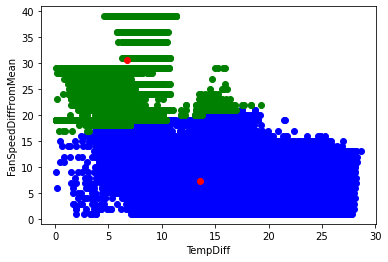

In [106]:
color=['blue','green']
for k in range(K):
    data=df_filtered[df_filtered["Cluster"]==k+1]
    plt.scatter(data["TempDiff"],data["FanSpeedDiffFromMean"],c=color[k])
plt.scatter(Centroids["TempDiff"],Centroids["FanSpeedDiffFromMean"],c='red')
plt.xlabel('TempDiff')
plt.ylabel('FanSpeedDiffFromMean')
plt.show()

In [88]:
#data.head()
from pathlib import Path  
filepath = Path('data/test.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df_filtered.to_csv(filepath)  
print(data)

Empty DataFrame
Columns: [Temp_Id, Date_Id, Location_Id, CoolingSource_Id, Temp_Out, Temp_Floor, Temp_Room, FanSpeed, ControllerStateNumber, FanSpeedDiffFromMean, TempDiff, MeanDiffLabel, 1, 2, Cluster]
Index: []


In [57]:
df_filtered.head()

,Temp_Id,Date_Id,Location_Id,CoolingSource_Id,Temp_Out,Temp_Floor,Temp_Room,FanSpeed,ControllerStateNumber,FanSpeedDiffFromMean,TempDiff,MeanDiffLabel,1,2,3,Cluster
108439,1265795,2021-06-01 00:01:00,2069,0,8.9,14.0,24.5,55,7.5,3.93074,15.6,1.0,10.509479,2.210180,31.462466,2
108440,1265796,2021-06-01 00:03:00,2069,0,8.7,13.8,25.1,61,7.5,9.93074,16.4,1.0,8.060655,4.200622,26.015674,2
108441,1265797,2021-06-01 00:05:00,2069,0,8.8,13.8,25.4,64,7.5,12.93074,16.6,1.0,8.151833,7.180876,23.321740,2
108442,1265798,2021-06-01 00:07:00,2069,0,8.9,14.0,25.4,64,7.5,12.93074,16.5,1.0,8.052965,7.185038,23.281014,2
108443,1265799,2021-06-01 00:09:00,2069,0,8.9,14.3,25.5,65,7.5,13.93074,16.6,1.0,8.359648,8.180348,22.412965,2


In [107]:

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
  

In [65]:
#df_filtered[[1,2]].round(decimals = 5)

,1,2,3
108439,10.50948,2.21018,31.46247
108440,8.06065,4.20062,26.01567
108441,8.15183,7.18088,23.32174
108442,8.05297,7.18504,23.28101
108443,8.35965,8.18035,22.41297
...,...,...,...
235810,18.37743,11.30574,30.58826
235811,18.17761,11.12831,30.45892
235812,18.40088,12.35014,29.09496
235813,18.06197,11.54263,29.63554


In [140]:
df1 = df_filtered.dropna()

In [261]:
alldatestart = '2021-01-01'
alldateend = '2021-12-31'

# create features
mask = (df['Date_Id'] > alldatestart) & (df['Date_Id'] <= alldateend)
df_anom = df.loc[mask]
temp_threshhold = 10
fanspeed_threshhold = 15



# define temperatur difference indicator
df_anom['RoomTempHigher'] = np.where(df_anom['Temp_Room'] > (df_anom['Temp_Out'] - temp_threshhold), 1, 0)
df_anom['TempDifFromMean'] = np.where((df_anom['Temp_Room'] - df_anom['Temp_Out']) > (df_anom['Temp_Room'].mean() - (df_anom['Temp_Out'].mean() + temp_threshhold)), 1, 0)

# define fanspeed difference from mean indicator
df_anom['FanSpeedHigherThanMean'] = np.where(df_anom['FanSpeed'] > (df_anom['FanSpeed'].mean() + fanspeed_threshhold), 1, 0)

# define abnormality from above features
df_anom['Abnormality'] = np.where(((df_anom['FanSpeedHigherThanMean'] == 1) & (df_anom['RoomTempHigher'] == 1)), 1, 0)

# define arobs
conditions = [
    (df_anom['FanSpeedHigherThanMean'] == 1) & (df_anom['RoomTempHigher'] == 1),
    (df_anom['FanSpeedHigherThanMean'] == 1) & (df_anom['RoomTempHigher'] == 0),
    (df_anom['FanSpeedHigherThanMean'] == 0) & (df_anom['RoomTempHigher'] == 1),
    (df_anom['FanSpeedHigherThanMean'] == 0) & (df_anom['RoomTempHigher'] == 0)
    ]
values = [1, 0, 0, 0]

# create a new column and use np.select to assign values to it using our lists as arguments
df_anom['Arobs'] = np.select(conditions, values)



C:\Users\OguzX\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\OguzX\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\OguzX\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

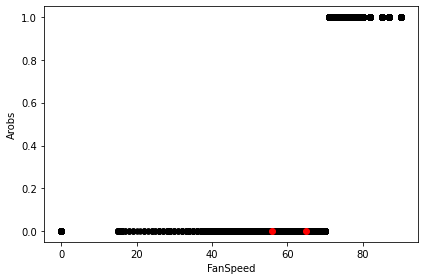

In [263]:
K=2
Centroids = (df_anom.sample(n=K))

# scatter 
plt.scatter(df_anom["FanSpeed"], df_anom["Arobs"], c="black", linewidths=0.1)
plt.scatter(Centroids["FanSpeed"],Centroids["Arobs"],c='red')
# label stuff
plt.xlabel('FanSpeed')
plt.ylabel('Arobs')

# eye candy
plt.tight_layout()
plt.show()

In [255]:
a = df_anom['Arobs'].value_counts()
g = df_anom['Abnormality'].value_counts()
e = df_anom['FanSpeedHigherThanMean'].value_counts()
f = df_anom['RoomTempHigher'].value_counts()
r = df_anom['TempDifFromMean'].value_counts()
print(r)

1    166241
0     69543
Name: TempDifFromMean, dtype: int64


In [256]:
print(df_anom)

31        0
32        0
33        0
34        0
35        0
         ..
235810    0
235811    0
235812    0
235813    0
235814    0
Name: Abnormality, Length: 235784, dtype: int32


In [176]:
df_clean = df_anom.dropna()
print(df_clean)

        Temp_Id             Date_Id  Location_Id  CoolingSource_Id  Temp_Out  \
32       196635 2021-01-01 00:04:00         2069                 0       5.0   
33       196636 2021-01-01 00:06:00         2069                 0       5.0   
34       196637 2021-01-01 00:08:00         2069                 0       5.0   
35       196638 2021-01-01 00:10:00         2069                 0       5.0   
36       196639 2021-01-01 00:12:00         2069                 0       5.0   
...         ...                 ...          ...               ...       ...   
235810  2214403 2021-11-30 22:51:00         2069                 0      -0.8   
235811  2214404 2021-11-30 22:53:00         2069                 0      -0.6   
235812  2214405 2021-11-30 22:55:00         2069                 0      -0.6   
235813  2214406 2021-11-30 22:57:00         2069                 0      -0.4   
235814  2214407 2021-11-30 22:59:00         2069                 0      -0.4   

        Temp_Floor  Temp_Room  FanSpeed

In [264]:
import matplotlib.pyplot as plt
import pandas as pd
# Importing the dataset using pandas module
dataset = df_anom[['FanSpeed','Temp_Out', 'Temp_Room', 'Abnormality']]

# splitting the dataset into input and output datasets
X = dataset.iloc[:, [0,1,2]].values
y = dataset.iloc[:, 3].values






In [265]:
print(X)

[[57.   5.  24.7]
 [68.   5.  25.8]
 [65.   5.  25.5]
 ...
 [64.  -0.6 26.3]
 [63.  -0.4 26.2]
 [64.  -0.4 26.4]]


In [266]:

# splitting the dataaset into Training and Testing Data 
from sklearn.model_selection import train_test_split

# random state is 0 and test size if 25%
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=0)

In [267]:

# importing standard scalling method from sklearn
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

# providing the inputs for the scalling purpose
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [268]:

# importing decision tree algorithm
from sklearn.tree import DecisionTreeClassifier

# entropy means information gain
classifer = DecisionTreeClassifier(criterion='entropy', random_state=0)

# providing the training dataset
classifer.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [269]:

y_pred = classifer.predict(X_test)


In [270]:

# importing the accuracy score
from sklearn.metrics import accuracy_score

# accuracy
accuracy_score(y_pred,y_test)

1.0

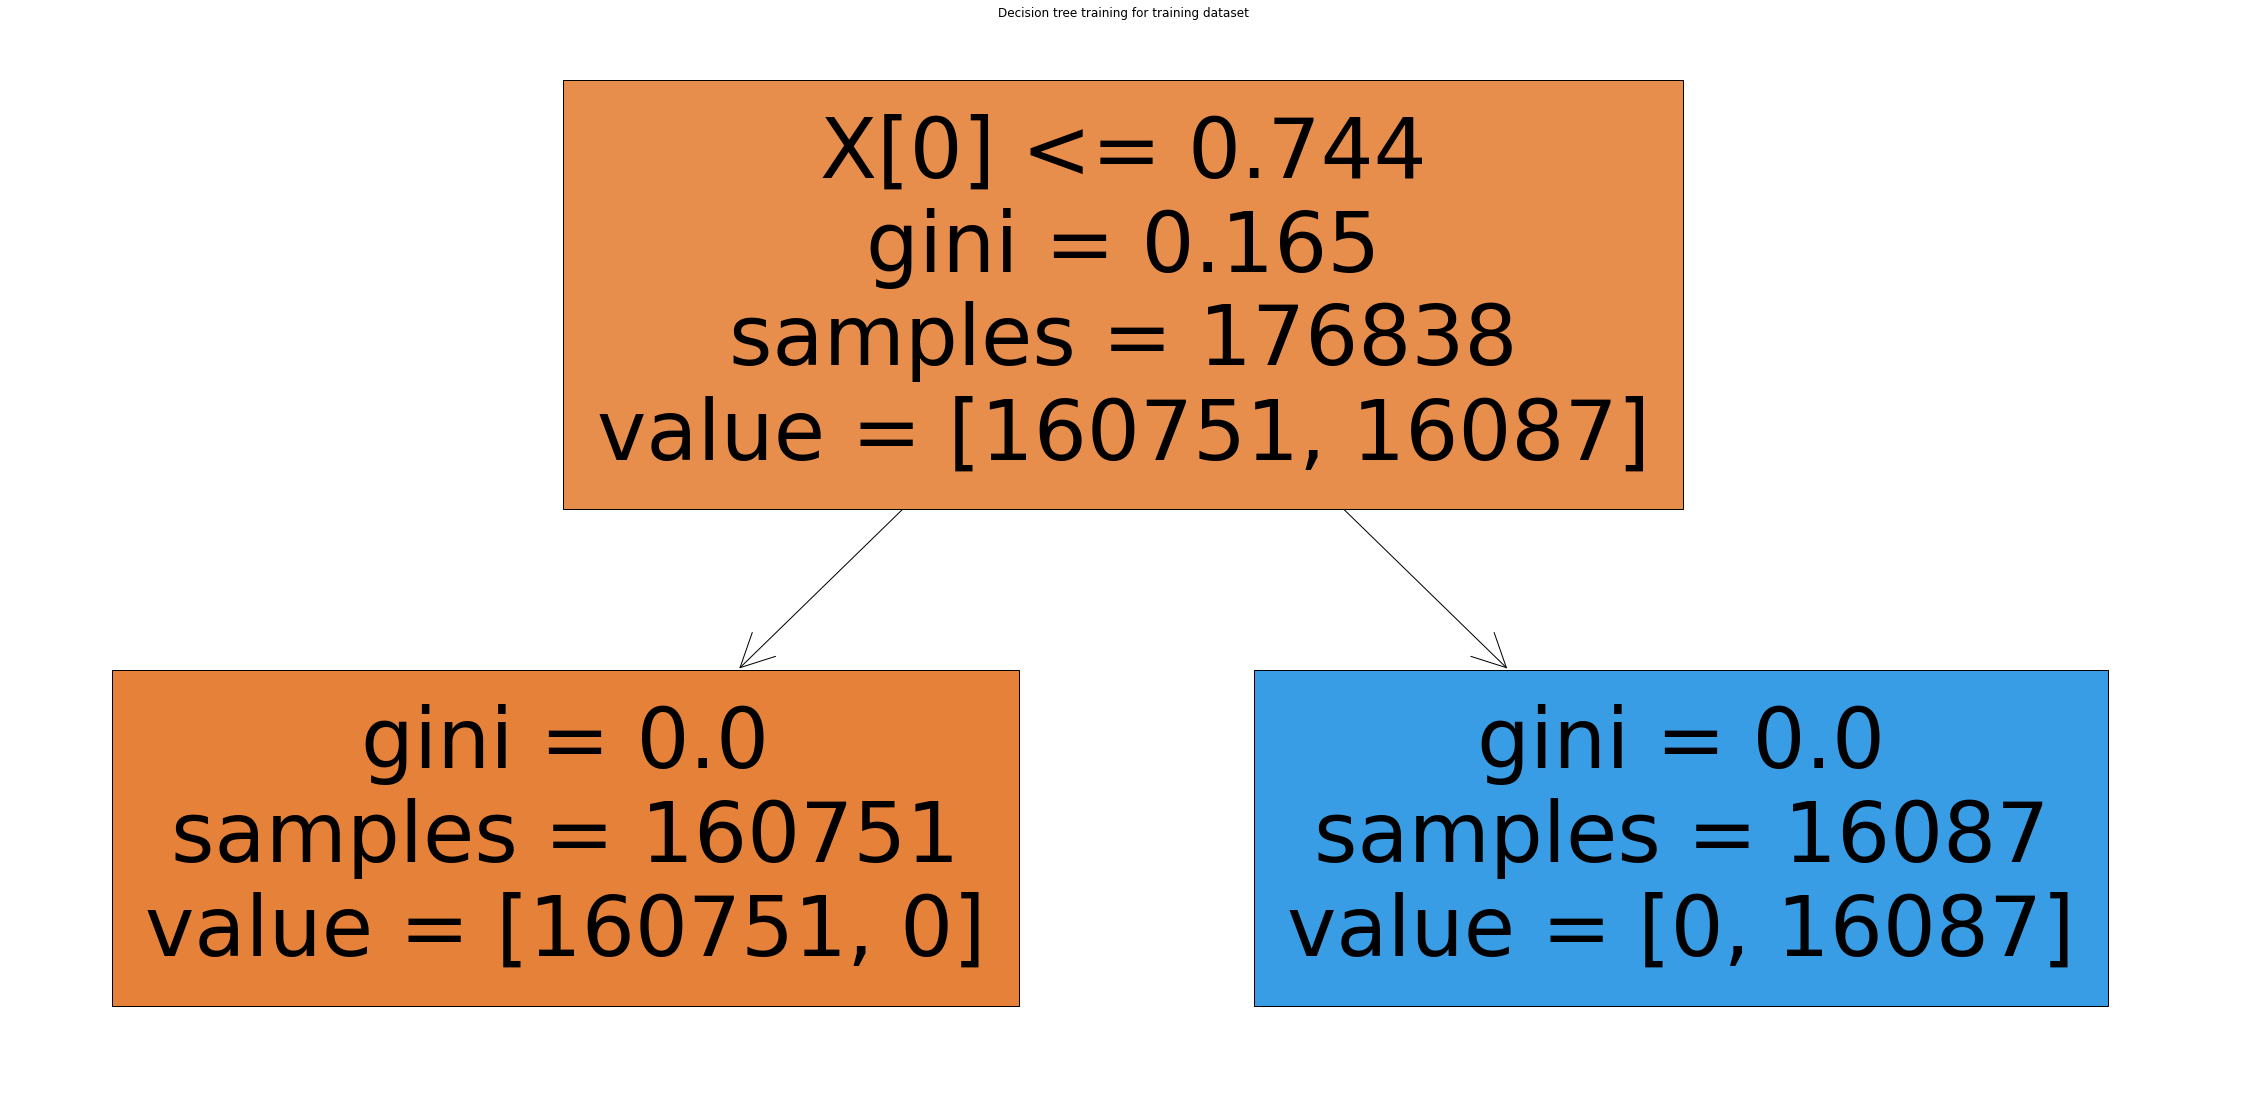

In [271]:
# importing the plot tree method
from sklearn.tree import DecisionTreeClassifier, plot_tree
clf = DecisionTreeClassifier()

# output size of decision tree
plt.figure(figsize=(40,20))

# providing the training dataset
clf = clf.fit(X_train, y_train)
plot_tree(clf, filled=True)
plt.title("Decision tree training for training dataset")
plt.show()

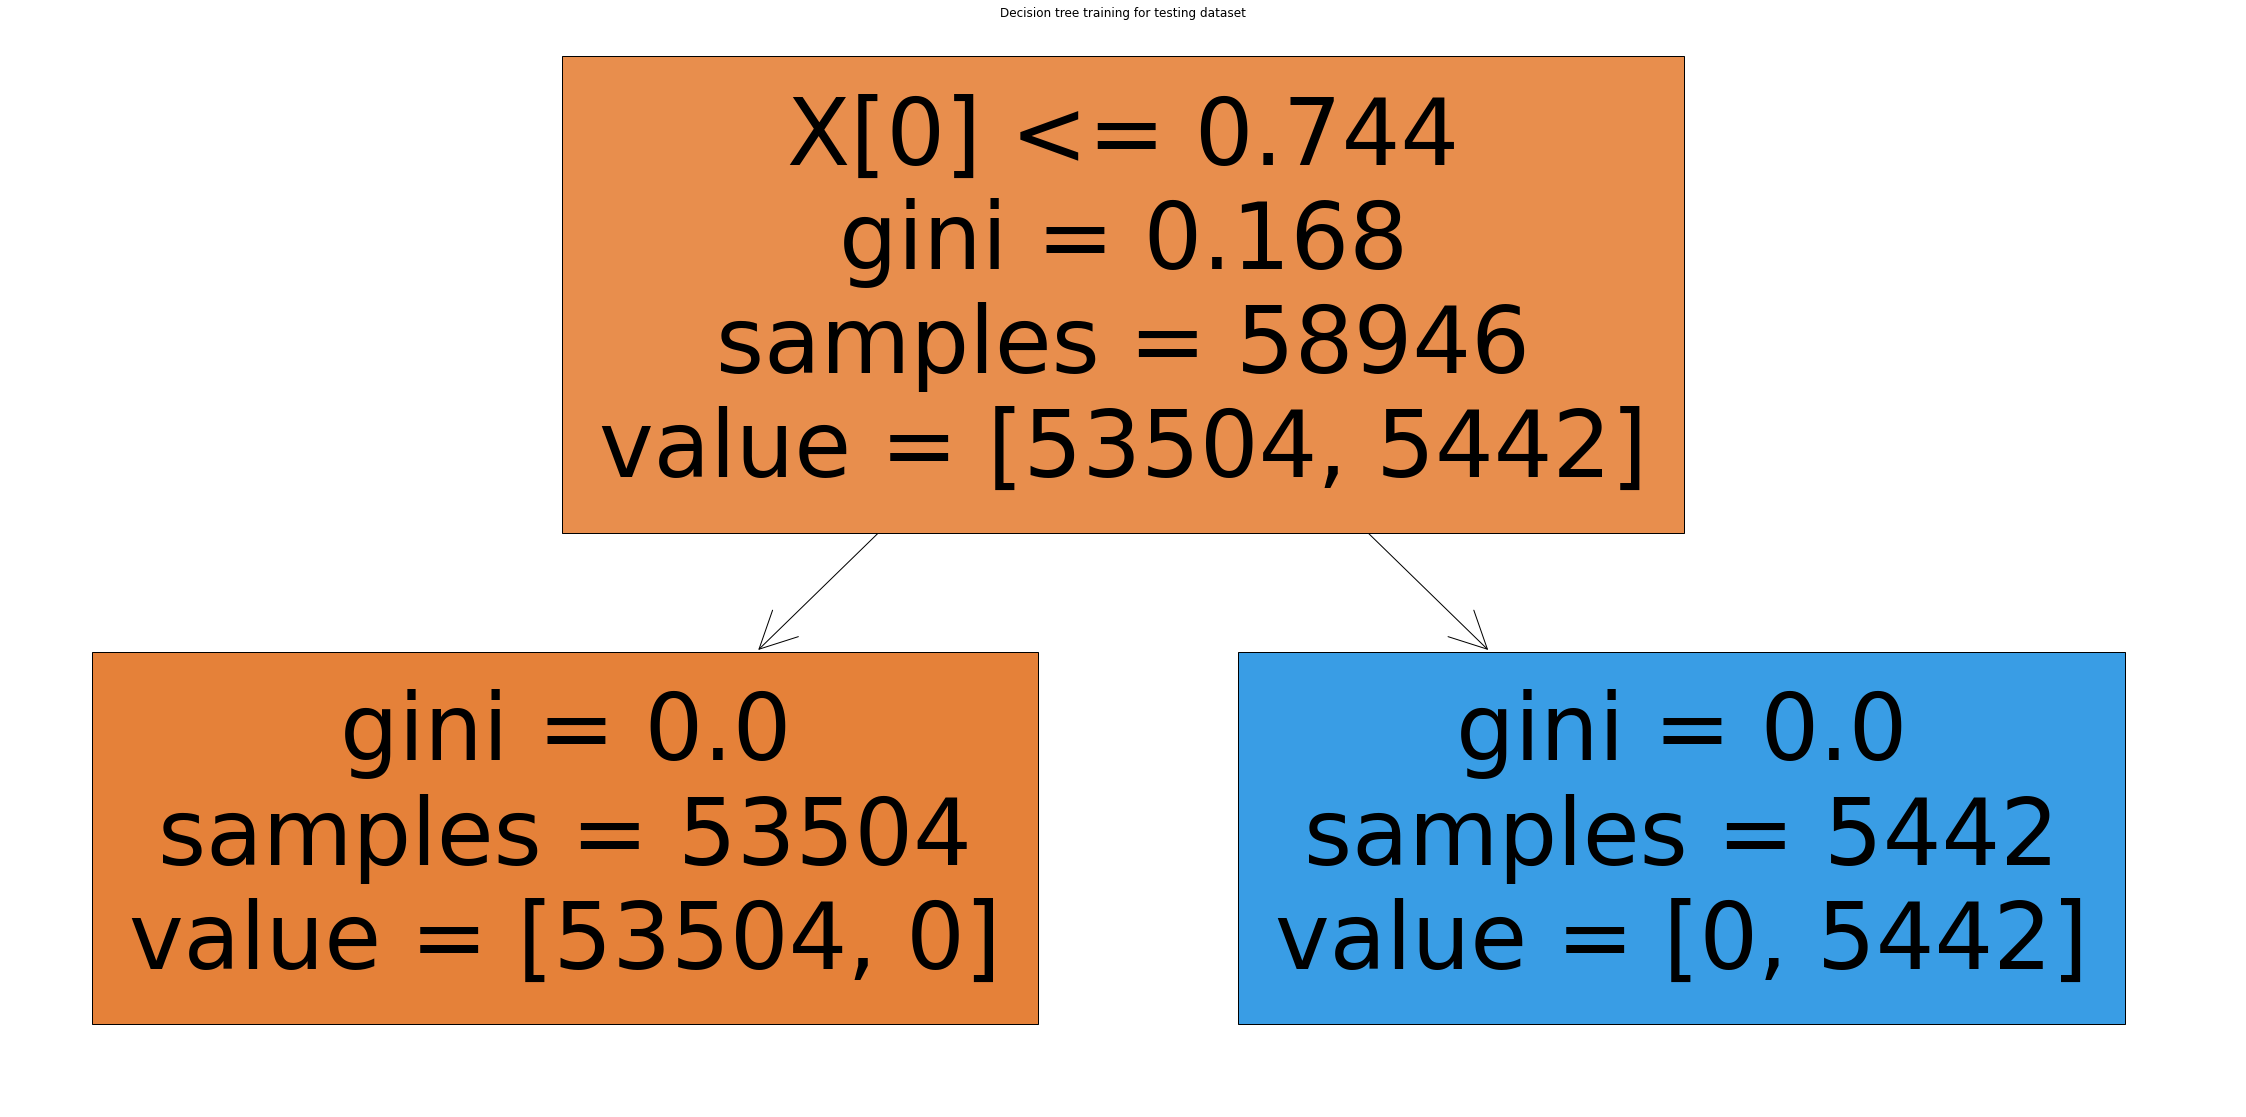

In [272]:
# importing the plot tree method
from sklearn.tree import DecisionTreeClassifier, plot_tree
clf = DecisionTreeClassifier()

# output size of decision tree
plt.figure(figsize=(40,20))

# providing the training dataset
clf = clf.fit(X_test, y_test)
plot_tree(clf, filled=True)
plt.title("Decision tree training for testing dataset")
plt.show()

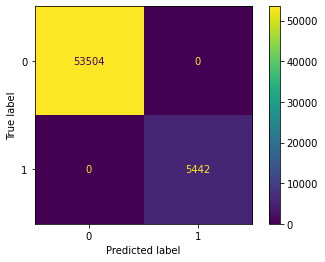

In [273]:
# importing the required modules
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Plot the confusion matrix in graph
cm = confusion_matrix(y_test,y_pred, labels=classifer.classes_)

# ploting with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifer.classes_)
disp.plot()

# showing the matrix
plt.show()

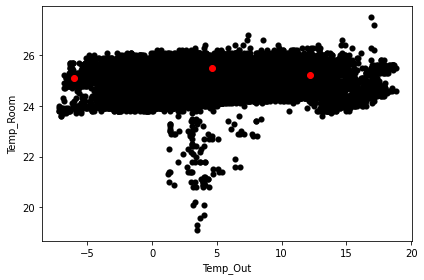

In [274]:
import numpy as np

# simple dates filter
alldatestart = '2021-03-01'
alldateend = '2021-03-31'

# dataset
# create features
mask = (df['Date_Id'] > alldatestart) & (df['Date_Id'] <= alldateend)
df_filtered = df.loc[mask]


df_difference_petro = df_filtered

# number of centroids
K=3
Centroids = (df_difference_petro.sample(n=K))

# scatter 
plt.scatter(df_difference_petro["Temp_Out"], df_difference_petro["Temp_Room"], c="black", linewidths=0.1)
plt.scatter(Centroids["Temp_Out"],Centroids["Temp_Room"],c='red')
# label stuff
plt.xlabel('Temp_Out')
plt.ylabel('Temp_Room')

# eye candy
plt.tight_layout()
plt.show()

#######
#######


C:\Users\OguzX\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\OguzX\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.587054229510523
0.49436024399197986
0.4335305093449837
0.3593119513563968
0.30007454744159046
0.1927006689499412
0.0004791919131326705
0.0011041378145604241
0.012449264325903542
0.10359038355847311
0.09402569364709495
0.0


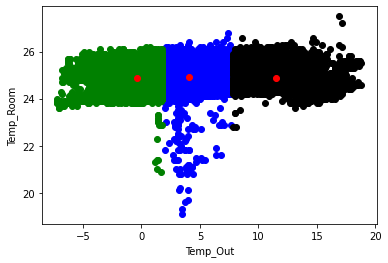

In [275]:

diff = 1
j=0

while(diff!=0):
    XD=df_difference_petro
    i=1
    for index1,row_c in Centroids.iterrows():
        ED=[]
        for index2,row_d in XD.iterrows():
            d1=(row_c["Temp_Out"]-row_d["Temp_Out"])**2
            d2=(row_c["Temp_Room"]-row_d["Temp_Room"])**2
            d=np.sqrt(d1+d2)
            ED.append(d)
        df_difference_petro[i]=ED
        i=i+1

    C=[]
    for index,row in df_difference_petro.iterrows():
        min_dist=row[1]
        pos=1
        for i in range(K):
            if row[i+1] < min_dist:
                min_dist = row[i+1]
                pos=i+1
        C.append(pos)
    df_difference_petro["Cluster"]=C
    Centroids_new = df_difference_petro.groupby(["Cluster"]).mean()[["Temp_Room","Temp_Out"]]
    if j == 0:
        diff=1
        j=j+1
    else:
        diff = (Centroids_new['Temp_Room'] - Centroids['Temp_Room']).sum() + (Centroids_new['Temp_Out'] - Centroids['Temp_Out']).sum()
        print(diff.sum())
    Centroids = df_difference_petro.groupby(["Cluster"]).mean()[["Temp_Room","Temp_Out"]]


color=['blue','green', 'black']
for k in range(K):
    data=df_difference_petro[df_difference_petro["Cluster"]==k+1]
    plt.scatter(data["Temp_Out"],data["Temp_Room"],c=color[k])
plt.scatter(Centroids["Temp_Out"],Centroids["Temp_Room"],c='red')
plt.xlabel('Temp_Out')
plt.ylabel('Temp_Room')
plt.show()

C:\Users\OguzX\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:31: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


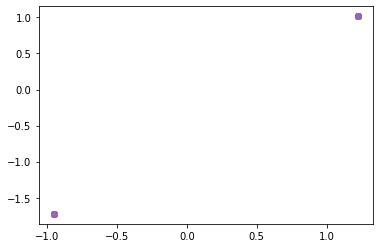

In [285]:
from numpy import unique
from numpy import where
from matplotlib import pyplot
from sklearn.datasets import make_classification
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
dbscan_model = DBSCAN(eps=0.25, min_samples=9)

# initialize the data set we'll work with
training_data, _ = make_classification(
    n_samples=1000,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_clusters_per_class=1,
    random_state=4
)

# define the model
kmeans_model = KMeans(n_clusters=2)

# assign each data point to a cluster
dbscan_result = dbscan_model.fit_predict(training_data)

# get all of the unique clusters
dbscan_clusters = unique(dbscan_result)

# plot the DBSCAN clusters
for dbscan_cluster in dbscan_clusters:
    # get data points that fall in this cluster
    index = where(dbscan_result == dbscan_clusters)
    # make the plot
    pyplot.scatter(training_data[ 0], training_data[ 1])

# show the DBSCAN plot
pyplot.show()

C:\Users\OguzX\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:36: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


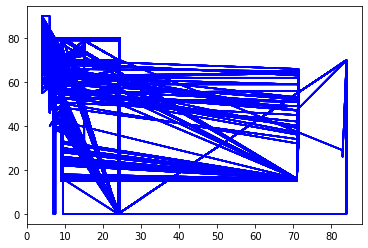

In [347]:
from numpy import unique
from numpy import where
from matplotlib import pyplot
from sklearn.datasets import make_classification
from sklearn.mixture import GaussianMixture

# initialize the data set we'll work with
training_data, _ = make_classification(
    n_samples=1000,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_clusters_per_class=1,
    random_state=4
)

dfff = df_anom[['FanSpeed', 'ControllerStateNumber', 'Temp_Out', 'Temp_Floor', 'Temp_Room']]
X = dfff['ControllerStateNumber']
y = dfff['FanSpeed']

# define the model
gaussian_model = GaussianMixture(n_components=12)

# train the model
gaussian_model.fit(dfff)

# assign each data point to a cluster
gaussian_result = gaussian_model.predict(dfff)

# get all of the unique clusters
gaussian_clusters = unique(gaussian_result)

# plot Gaussian Mixture the clusters
for gaussian_cluster in gaussian_clusters:
    # get data points that fall in this cluster
    index = where(gaussian_result == gaussian_clusters)
    # make the plot
    pyplot.scatter(dfff['ControllerStateNumber'], dfff['FanSpeed'], c='b')

# show the Gaussian Mixture plot
pyplot.show()

In [305]:

def plotCorrelationMatrix(df, graphWidth):
    #filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix', fontsize=15)
    plt.show()



C:\Users\OguzX\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


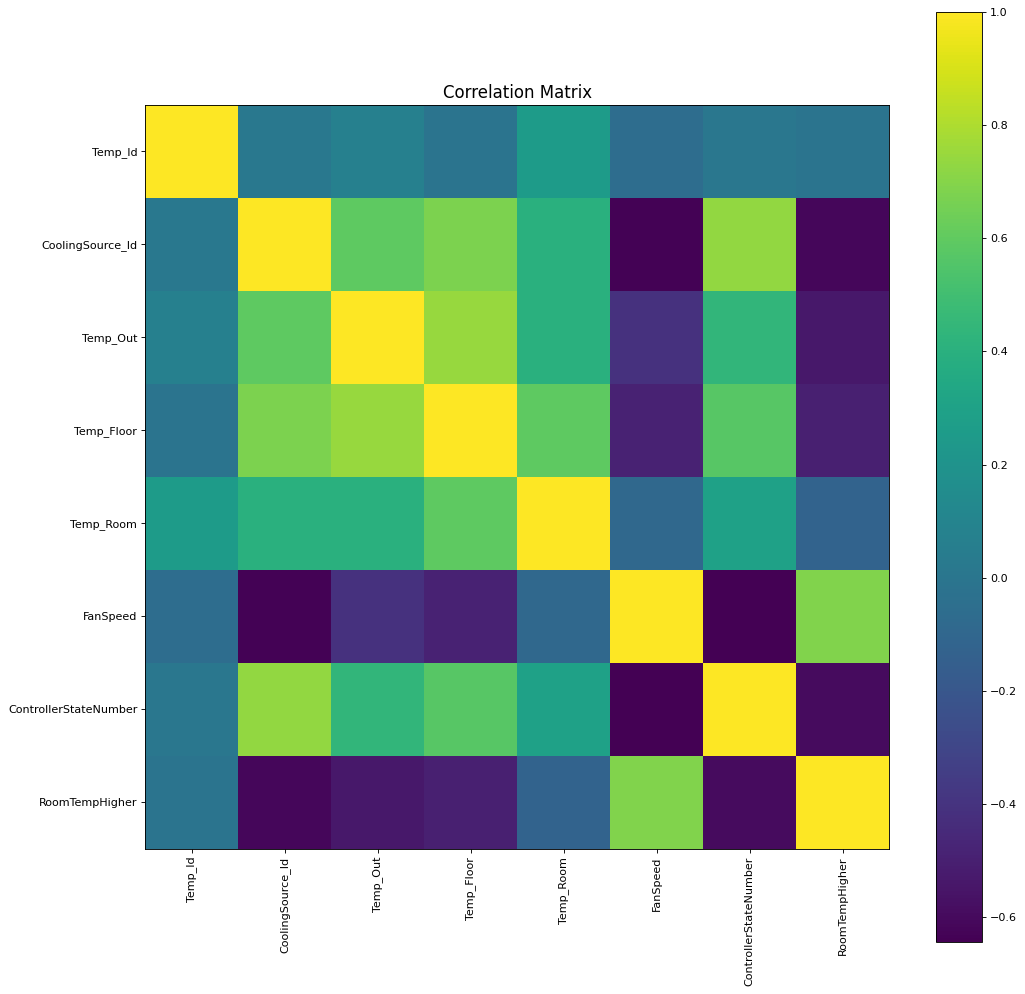

In [348]:
plotCorrelationMatrix(df, 15)

In [333]:
select_df = df.drop(['Temp_Id', 'Location_Id', 'Date_Id', 'RoomTempHigher', 'FanSpeedHigherThanMean', 'Abnormality'], 1)
select_df.describe().transpose()

C:\Users\OguzX\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


,count,mean,std,min,25%,50%,75%,max
CoolingSource_Id,333629.0,0.105069,0.338319,0.0,0.0,0.0,0.0,2.0
Temp_Out,333629.0,9.744159,8.933181,-19.8,2.7,8.7,15.6,43.0
Temp_Floor,333629.0,16.844175,2.882096,6.2,14.9,16.2,17.4,30.9
Temp_Room,333629.0,25.595678,1.027625,18.0,25.0,25.5,26.0,32.9
FanSpeed,333629.0,56.088068,18.045047,0.0,54.0,59.0,64.0,90.0
ControllerStateNumber,333629.0,8.647105,6.617204,4.0,7.0,7.0,7.5,84.0


In [334]:
select_df.dropna()
X = StandardScaler().fit_transform(select_df)


In [335]:
kmeans = KMeans(n_clusters=12)
model = kmeans.fit(X)
print("model\n", model)

model
 KMeans(n_clusters=12)


In [ ]:
centers = model.cluster_centers_
print(centers)

In [337]:
features = ['Temp_Out', 'Temp_Room', 'FanSpeed', 'Temp_Floor']
select_df = select_df[features]
select_df.columns

Index(['Temp_Out', 'Temp_Room', 'FanSpeed', 'Temp_Floor'], dtype='object')

In [339]:
Z = StandardScaler().fit_transform(select_df)

In [340]:
kmeans = KMeans(n_clusters=12)
model = kmeans.fit(Z)
print("model\n", model)

model
 KMeans(n_clusters=12)


In [ ]:
centers = model.cluster_centers_
centers

In [343]:
def pd_centers(featuresUsed, centers):
	colNames = list(featuresUsed)
	colNames.append('prediction')

	# Zip with a column called 'prediction' (index)
	Z = [np.append(A, index) for index, A in enumerate(centers)]

	# Convert to pandas data frame for plotting
	P = pd.DataFrame(Z, columns=colNames)
	P['prediction'] = P['prediction'].astype(int)
	return P



In [344]:
P = pd_centers(features, centers)
P

,Temp_Out,Temp_Room,FanSpeed,Temp_Floor,prediction
0,-0.523552,0.553213,0.484401,-0.155964,0
1,2.062223,3.742611,-3.091768,3.636970,1
2,-1.021222,-1.137921,-0.227620,-0.401748,2
3,2.035458,-1.115425,-3.073642,1.589614,3
4,1.345744,1.583117,1.051918,1.535497,4
5,2.110019,1.494911,-3.085908,2.361318,5
6,-0.331316,-0.460474,0.028149,-0.112381,6
7,0.367750,-0.711753,-0.054518,-0.552579,7
8,0.926424,0.135163,1.616039,0.975159,8
9,-0.163504,0.169852,0.294570,-0.815119,9


In [ ]:
# if there are multiple runs, iterate over the desired run to register a specific run
runs = list(experiment.get_runs())
run_id = runs[0].id
submitting_run = ws.get_run(run_id)
submitting_run

In [1]:
import pandas

pds = pandas

xas = [1,2,3]

df = pd.data

In [11]:
# service script for deployment of the algorithm

#imports
import joblib
from azureml.core import Model
import json
import pandas as pd

#import pandas as pd

# init function for service deployment
def init():
    global ref_cols, predictor
    model_path = Model.get_model_path('ClusterAlgorithm_01')
    ref_cols, predictor = joblib.load(model_path)

# run function for predictions
def run(raw_data):
    # load data
    data_dict = json.loads(raw_data)

    # convert to dataframe
    #data = pd.DataFrame.from_dict(data_dict)
    data = pd.DataFrame.from_dict(data_dict)

    # hot encode once again
    '''
    data_enc = pd.get_dummies(data)

    # columns reference
    deploy_cols = data_enc.columns

    # compare to get number of missing columns
    missing_cols = ref_cols.difference(deploy_cols)

    # check for missing colums
    for cols in missing_cols:
        data_enc[cols] = 0

    # insert all columns
    data_enc = data_enc[ref_cols]
    '''
    # prediction
    #predictions = predictor.predict(data_enc)
    algo_model = predictor(sklearn_load_ds=data)
    predictions = algo_model.Kmeans(output='replace').classify()

  

    '''
    
    # returned result format
    classes = ['Abnormal', 'Normal']
    # list of predictions
    predicted_classes = []
    
    for prediction in predictions:
        predicted_classes.append(classes[prediction])
    '''

    return json.dumps(predictions)

In [7]:
from azureml.core import Workspace


ws = Workspace.from_config('./config/config.json')

service = ws.webservices['clustermodel-service']

import json

x_new = {
    'Temp_Id': 123123123,
    'Date_Id': '2022-05-05 00:02:00',
    'Location_Id': 2069,
    'CoolingSource_Id': 0,
    'Temp_Out': 18,
    'Temp_Floor': 12,
    'Temp_Room': 21,
    'FanSpeed': 12,
    'ControllerStateNumber': 10.2
}

json_data = json.dumps({"data": x_new})

response = service.run(input_data = json_data)

predicted_classes = json.loads(response)

print(predicted_classes)

KeyError: 'clustermodel-service'

In [13]:
x_new = {
    'Temp_Id': 123123123,
    'Date_Id': '2022-05-05 00:02:00',
    'Location_Id': 2069,
    'CoolingSource_Id': 0,
    'Temp_Out': 18,
    'Temp_Floor': 12,
    'Temp_Room': 21,
    'FanSpeed': 12,
    'ControllerStateNumber': 10.2
}

json_data = json.dumps({"data": x_new})
init()
run(json_data)

ModelNotFoundException: ModelNotFoundException:
	Message: Model ClusterAlgorithm_01 not found in cache at azureml-models or in current working directory c:\Users\OguzX\Desktop\BA mats\Notebooks. For more info, set logging level to DEBUG.
	InnerException None
	ErrorResponse 
{
    "error": {
        "message": "Model ClusterAlgorithm_01 not found in cache at azureml-models or in current working directory c:\\Users\\OguzX\\Desktop\\BA mats\\Notebooks. For more info, set logging level to DEBUG."
    }
}